In [1]:
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

import matplotlib.pyplot as plt

In [17]:
def make_data(N):
    X = torch.rand((N, 1)) * 4 - 2
    y = torch.cos(X) + 0.1 * torch.randn((N, 1))
    return X, y

N = 10
X_train, y_train = make_data(N)
X_test , y_test = make_data(4000)

In [18]:
def model(x):
    w0 = pyro.sample('w0', dist.Normal(torch.zeros(1, 2), torch.ones(1, 2)))
    w1 = pyro.sample('w1', dist.Normal(torch.zeros(2, 1), torch.ones(2, 1)))
    b0 = pyro.sample('b0', dist.Normal(torch.zeros(2), torch.ones(2)))
    b1 = pyro.sample('b1', dist.Normal(torch.zeros(1), torch.ones(1)))
    return pyro.sample('y', dist.Normal(torch.tanh(x @ w0 + b0) @ w1 + b1, 0.1))

def guide(x):
    w0 = pyro.sample('w0', dist.Normal(
        pyro.param('qw0/loc', 0.01 * torch.randn(1, 2)),
        pyro.param('qw0/scale', torch.ones(1, 2), constraint=constraints.positive)))
    w1 = pyro.sample('w1', dist.Normal(
        pyro.param('qw1/loc', 0.01 * torch.randn(2, 1)),
        pyro.param('qw1/scale', torch.ones(2, 1), constraint=constraints.positive)))
    b0 = pyro.sample('b0', dist.Normal(
        pyro.param('qb0/loc', 0.01 * torch.randn(2)),
        pyro.param('qb0/scale', torch.ones(2), constraint=constraints.positive)))
    b1 = pyro.sample('b1', dist.Normal(
        pyro.param('qb1/loc', 0.01 * torch.randn(1)),
        pyro.param('qb1/scale', torch.ones(1), constraint=constraints.positive)))
    return pyro.sample('y', dist.Normal(torch.tanh(x @ w0 + b0) @ w1 + b1, 0.1))

conditioned_model = pyro.condition(model, data={'y': y_train})


In [19]:
class Averager:
    def __init__(self, alpha=0.98):
        self.alpha = alpha
        self.sum = 0
        self.x = 0
    
    def __call__(self, x):
        self.x = self.alpha * self.x + (1 - self.alpha) * x
        self.sum = self.alpha * self.sum + (1 - self.alpha)
        return self.x / self.sum

Step     0 Loss 1653.495
Step   500 Loss 293.068
Step  1000 Loss 164.505
Step  1500 Loss 140.098
Step  2000 Loss 123.938
Step  2500 Loss 111.674
Step  3000 Loss 105.862
Step  3500 Loss 102.998
Step  4000 Loss 94.197
Step  4500 Loss 76.893
Step  5000 Loss 61.085
Step  5500 Loss 34.449
Step  6000 Loss 26.449
Step  6500 Loss 24.194
Step  7000 Loss 23.272
Step  7500 Loss 23.313
Step  8000 Loss 22.435
Step  8500 Loss 23.362
Step  9000 Loss 22.642
Step  9500 Loss 22.670
Step 10000 Loss 22.537
Step 10500 Loss 21.881
Step 11000 Loss 22.350
Step 11500 Loss 22.728
Step 12000 Loss 21.673
Step 12500 Loss 22.899
Step 13000 Loss 22.378
Step 13500 Loss 22.384
Step 14000 Loss 22.736
Step 14500 Loss 22.519
Step 15000 Loss 22.373
Step 15500 Loss 22.363


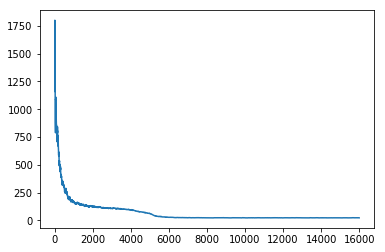

In [20]:
pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned_model
                    ,guide=guide
                    ,optim=pyro.optim.Adam({'lr': 0.005})
                    ,loss=pyro.infer.Trace_ELBO())

losses = []
loss_avg = Averager()
for step in range(16000):
    losses.append(loss_avg(svi.step(X_train)))
    if step % 500 == 0:
        print('Step {:>5d} Loss {:.3f}'.format(step, losses[-1]))

plt.plot(losses)

In [22]:
w0 = pyro.param('qw0/loc')
w1 = pyro.param('qw1/loc')
b0 = pyro.param('qb0/loc')
b1 = pyro.param('qb1/loc')

y_pred = torch.tanh(X_test @ w0 + b0) @ w1 + b1

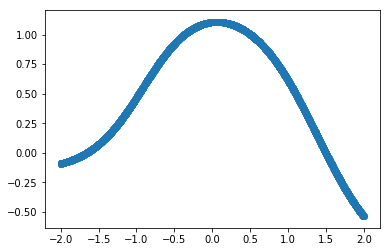

In [23]:
plt.scatter(X_test, y_pred.detach().numpy())

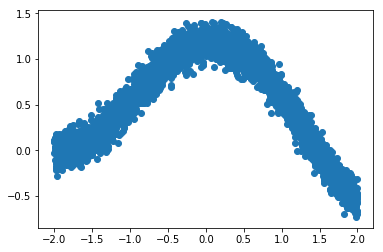

In [24]:
plt.scatter(X_test, guide(X_test).detach())

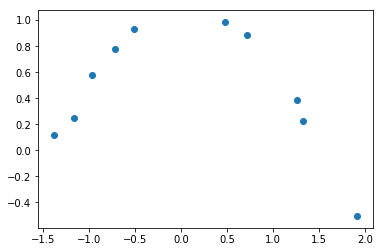

In [25]:
plt.scatter(X_train, y_train)